In [ ]:
import os
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
from pyspark.sql.functions import col, current_timestamp, to_date, hour, dayofweek

import numpy as np

from itertools import combinations

In [4]:
def create_new_spark_context(appName):
    return SparkSession.builder.appName(appName)\
        .master("local[*]").getOrCreate()


spark_session = create_new_spark_context("LSH")
sc = spark_session.sparkContext


In [5]:
schema = StructType([
    StructField("DEVICE_CODE", IntegerType(), True),
    StructField("SYSTEM_ID", IntegerType(), True),
    StructField("ORIGINE_CAR_KEY", StringType(), True),
    StructField("FINAL_CAR_KEY", StringType(), True),
    StructField("CHECK_STATUS_KEY", IntegerType(), True),
    StructField("COMPANY_ID", StringType(), True),
    StructField("PASS_DAY_TIME", TimestampType(), True)
])

In [81]:
df = spark_session.read.csv(
    '/content/drive/MyDrive/MDA/Project/TrafficData.csv', header=True, schema=schema)


First we remove the outliers from the data. Namely the cars that have been recorded more than 1000 times. We can do this by using the following code:

In [82]:
# add count column to count the number of records, group by FINAL_CAR_KEY
# define a window to count the number of records for each car

from pyspark.sql.window import Window
from pyspark.sql.functions import count

window = Window.partitionBy("FINAL_CAR_KEY")
df = df.withColumn("COUNT", count("*").over(window))

# remove cars with moe than 1000 records
df = df.filter(col("COUNT") < 1000)
df.show(5)


+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|COUNT|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
|   22010053|      284|       10000007|     10000007|               5|       161|2022-01-12 06:30:27|    1|
|     900233|      283|       10000016|     10000016|               5|       264|2022-01-14 13:57:13|    1|
|     900242|      283|       10000048|     10000048|               5|       264|2022-01-09 21:58:56|    9|
|     101301|       81|       10000048|     10000048|               5|       161|2022-01-09 21:54:31|    9|
|        135|       81|       10000048|     10000048|               5|       161|2022-01-09 21:36:46|    9|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
only showing top 5 rows



Now We filter the cars that have been recorded frequently. For example, those recorded more than 100 times. We can do this by using the following code:

In [83]:
# add HOUR_OF_WEEK column
from pyspark.sql.functions import hour, dayofweek, col

df = df.withColumn("HOUR_OF_WEEK", (dayofweek(col("PASS_DAY_TIME")) - 1) * 24 + hour(col("PASS_DAY_TIME")))


In [84]:
# select DEVICE_CODE, HOUR_OF_WEEK
df = df.select("DEVICE_CODE", "HOUR_OF_WEEK", "FINAL_CAR_KEY", "SYSTEM_ID")

# convert to spark rdd and group by key to add the column count of records for device_code, hour_of_week
grouped_df = df.groupBy("DEVICE_CODE", "HOUR_OF_WEEK").count()
grouped_df.show(5)

+-----------+------------+-----+
|DEVICE_CODE|HOUR_OF_WEEK|count|
+-----------+------------+-----+
|  100700839|         142|  761|
|     900222|          81| 3921|
|  100700898|         113|    3|
|     631361|          89|  957|
|     900129|          55|  162|
+-----------+------------+-----+
only showing top 5 rows



## CF using ALS

Here we use the Alternating Least Squares (ALS) algorithm to build a collaborative filtering model. We use the pyspark.ml.recommendation.ALS class to build the model.

In [85]:
from pyspark.ml.recommendation import ALS


# define ALS model
als = ALS(maxIter=5,
          regParam=0.01,
          userCol="DEVICE_CODE",
          itemCol="HOUR_OF_WEEK",
          ratingCol="count",
          coldStartStrategy="drop")


# fit the model
train, test = grouped_df.randomSplit([0.8, 0.2])
model = als.fit(train)


#### Evaluation

We use the Root Mean Squared Error (RMSE) to evaluate the model. We can use the pyspark.ml.evaluation.RegressionEvaluator class to evaluate the model.

In [86]:
from pyspark.ml.evaluation import RegressionEvaluator

# evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)

In [87]:
predictions.show(5)

+-----------+------------+-----+----------+
|DEVICE_CODE|HOUR_OF_WEEK|count|prediction|
+-----------+------------+-----+----------+
|        100|          18| 1026|  960.2455|
|        100|          24|  217| 206.23524|
|        100|          28|   28| 33.774128|
|        100|          59|  622|  532.8242|
|        100|          80|  509|  560.1146|
+-----------+------------+-----+----------+
only showing top 5 rows



In [91]:
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 92.20055391998214


Now we find the most similar devices to the device with id 1. We can do this by using the following code:

In [ ]:
# get a random device code
rdd = df.rdd.map(lambda x: (x["DEVICE_CODE"], x["HOUR_OF_WEEK"]))
rdd = rdd.map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda x, y: x + y)
device_code = rdd.takeSample(False, 1)[0][0][0]

In [99]:
device_code

22010043

In [92]:
# get factorized matrices for device_code
deviceFactors = model.userFactors

# get the row for device_code
device_row = deviceFactors.filter(deviceFactors.id == device_code).first()

# compute the cosine similarity between device_code and all other device_codes
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

def cosine_similarity(v1, v2):
    return float(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))


# convert deviceFactors to rdd
deviceFactors_rdd = deviceFactors.rdd.map(lambda x: (x["id"], x["features"]))

# for each row in deviceFactors, compute the cosine similarity with device_row
similarities = deviceFactors_rdd.map(lambda x: (x[0], cosine_similarity(x[1],
                                    device_row["features"]))).toDF(["device_code", "similarity"])\
                                        .filter(col("device_code") != device_code)

# get the top 10 similar device_codes
similarities.orderBy(col("similarity").desc()).show(10)

+-----------+------------------+
|device_code|        similarity|
+-----------+------------------+
|   22010044|0.9670791726505334|
|     900227|0.8183656037733871|
|   22009973|0.8092162497154531|
|     900256|0.7896699275976415|
|   22009909|0.7886760237867068|
|     635619|0.7747928235649074|
|    1001004|0.7736895242287394|
|  100701131|0.7671274807129105|
|   22010112|0.7598339387431378|
|    1001017|0.7490617187759447|
+-----------+------------------+
only showing top 10 rows



plot similarity distribution for device_code

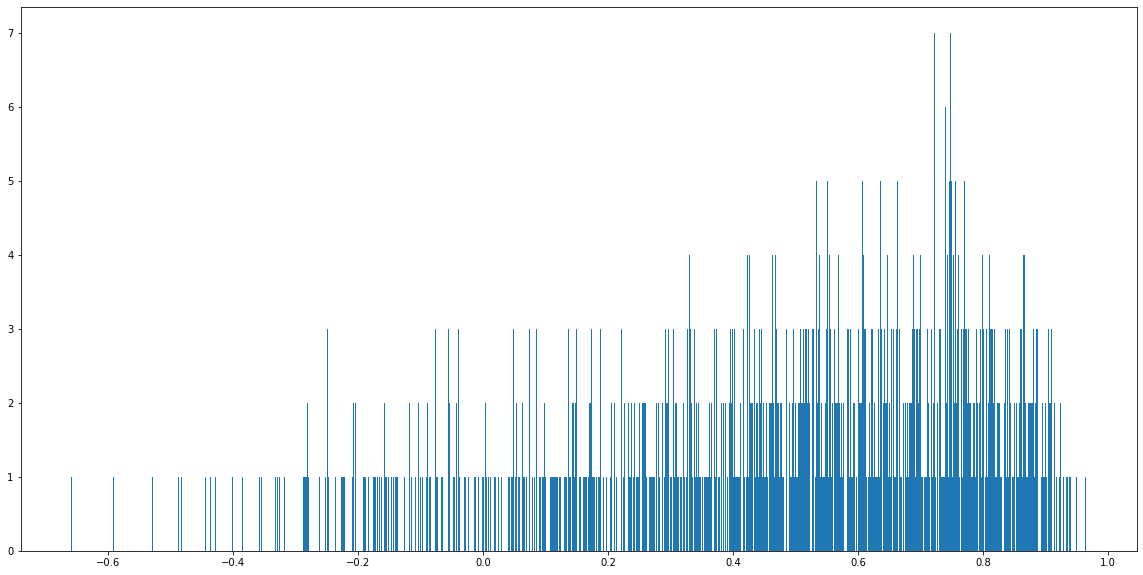

In [40]:
import matplotlib.pyplot as plt

similarities_pd = similarities.toPandas()

plt.figure(figsize=(20, 10))
plt.hist(similarities_pd["similarity"], bins=1000)
plt.show()

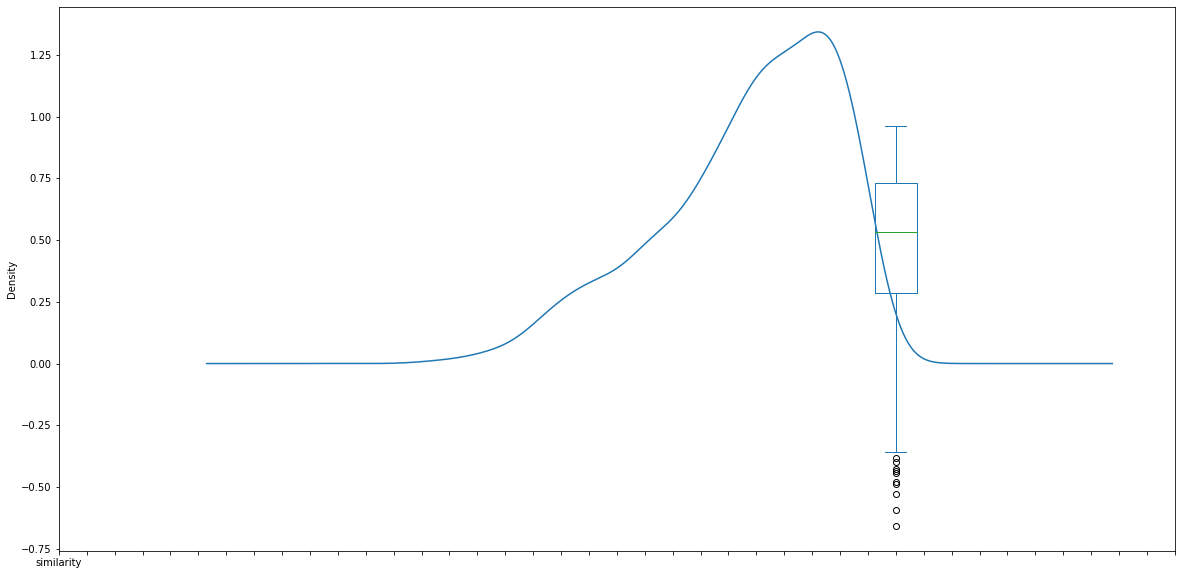

In [46]:
plt.figure(figsize=(20, 10))
similarities_pd["similarity"].plot.kde()
similarities_pd["similarity"].plot.box()

# add label and xticks
plt.ylabel("Density")
plt.xticks(np.arange(-2.0, 2.1, 0.1))

plt.show()


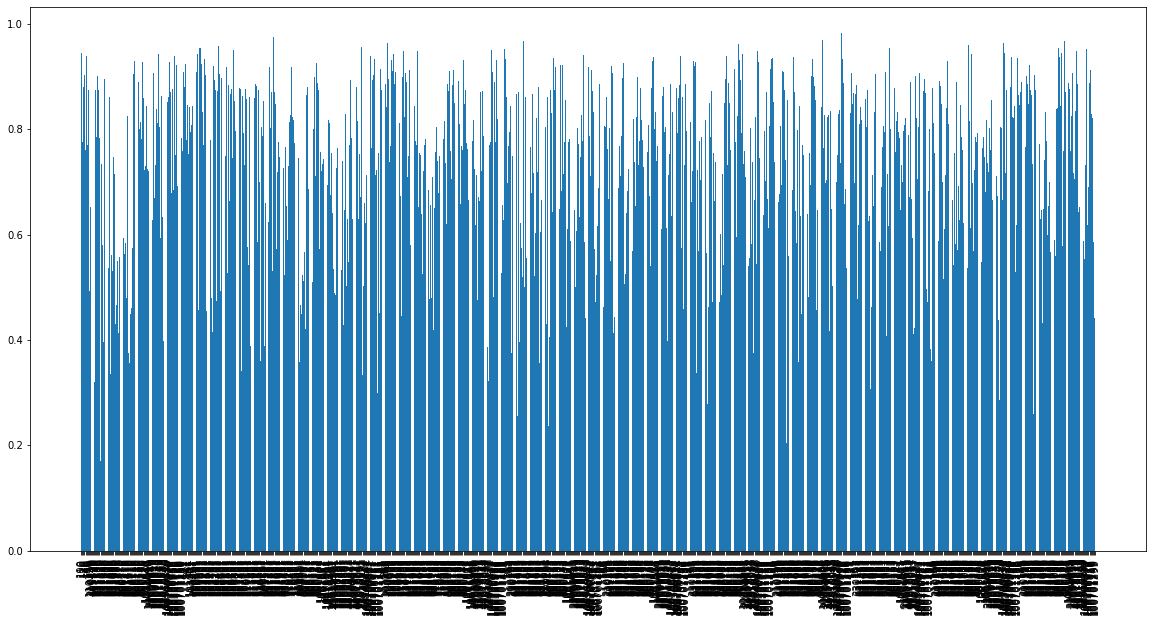

In [52]:
# plot bar chart for all device_codes
similarities_pd = similarities.toPandas()
similarities_pd["device_code"] = similarities_pd["device_code"].astype(str)

plt.figure(figsize=(20, 10))
plt.bar(similarities_pd["device_code"], (similarities_pd["similarity"] + 1) / 2)
plt.xticks(rotation=90)
plt.show()

In [54]:
# get type of top 100 similar device_codes with device_code
import pandas as pd

# get top 100 similar device_codes
top_100 = similarities.orderBy(col("similarity").desc()).limit(100).toPandas()

# get the type of each device_code
device_code_type = df.select("DEVICE_CODE", "SYSTEM_ID").distinct().toPandas()

# merge the two dataframes
top_100 = pd.merge(top_100, device_code_type, left_on="device_code", right_on="DEVICE_CODE")


In [55]:
top_100

,device_code,similarity,DEVICE_CODE,SYSTEM_ID
0,100701096,0.964479,100701096,283
1,631781,0.949487,631781,81
2,100700965,0.939276,100700965,283
3,900266,0.938007,900266,283
4,900199,0.934916,900199,283
...,...,...,...,...
95,710401,0.834061,710401,83
96,1001063,0.833629,1001063,83
97,102,0.829208,102,81
98,106,0.827144,106,81


In [57]:
top_100['SYSTEM_ID'].unique()

array([283,  81, 182,  83, 102], dtype=int32)

Here we change the length of time intervals and repeat the computations

In [93]:
# use 6 hour intervals
new_df = df.withColumn("HOUR_OF_WEEK", ((col("HOUR_OF_WEEK") / 6)).cast("integer"))


# select DEVICE_CODE, HOUR_OF_WEEK
new_df = new_df.select("DEVICE_CODE", "HOUR_OF_WEEK", "FINAL_CAR_KEY")

# convert to spark rdd and group by key to add the column count of records for device_code, hour_of_week
grouped_df = new_df.groupBy("DEVICE_CODE", "HOUR_OF_WEEK").count()



# define ALS model
als = ALS(maxIter=5,
          regParam=0.01,
          userCol="DEVICE_CODE",
          itemCol="HOUR_OF_WEEK",
          ratingCol="count",
          coldStartStrategy="drop")


# fit the model
train, test = grouped_df.randomSplit([0.8, 0.2])

model = als.fit(train)


# evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)

In [94]:
predictions.show(5)

+-----------+------------+-----+----------+
|DEVICE_CODE|HOUR_OF_WEEK|count|prediction|
+-----------+------------+-----+----------+
|        100|           4|  529| 557.89124|
|        100|          19| 4224| 4869.5107|
|        101|           3|  239| 245.19199|
|        101|          21|  115| 105.95039|
|        102|           9|  414| 378.54663|
+-----------+------------+-----+----------+
only showing top 5 rows



In [96]:
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 886.6702653079421


In [97]:
# get factorized matrices for device_code
deviceFactors = model.userFactors

# get the row for device_code
device_row = deviceFactors.filter(deviceFactors.id == device_code).first()


# convert deviceFactors to rdd
deviceFactors_rdd = deviceFactors.rdd.map(lambda x: (x["id"], x["features"]))

# for each row in deviceFactors, compute the cosine similarity with device_row
similarities = deviceFactors_rdd.map(lambda x: (x[0], cosine_similarity(x[1],
                                    device_row["features"]))).toDF(["device_code", "similarity"])\
                                        .filter(col("device_code") != device_code)

# get the top 10 similar device_codes
similarities.orderBy(col("similarity").desc()).show(10)

+-----------+------------------+
|device_code|        similarity|
+-----------+------------------+
|   22010055|0.9595526022964109|
|   22010037|0.9323351309597874|
|   22009823|0.9030423531924506|
|   22010036|   0.8945558401846|
|     631932| 0.869717163056744|
|     631833|0.8684746345687716|
|   22009868|0.8683260015790416|
|   22010047|0.8658915635876753|
|   22010056| 0.861299180012631|
|   22010120|  0.85871985072689|
+-----------+------------------+
only showing top 10 rows



## CF With KNN

In [100]:
device_code =114

In [28]:
# get paris of (DEVICE_CODE, TIME) with the same time
# we do this by joining the rdd with itself on the time, which at first we convert to a key
time_device = rdd.map(lambda x: (x[0][1], (x[0][0], x[1])))
time_device_pairs = time_device.join(time_device)


In [29]:
# Convert each time and co_counting device pairs to a new vector
# keyed on the device pair codes, with the co_counts as their value.

def keyOnDevicePair(device_count_pair):
    device_1, device_2 = device_count_pair[0][0], device_count_pair[1][0]
    device_1_count, device_2_count = device_count_pair[0][1], device_count_pair[1][1]
    return (device_1, device_2), (device_1_count, device_2_count)

device_time_count_pairs = time_device_pairs.map(lambda x: keyOnDevicePair(x[1]))\
    .filter(lambda x: x[0][0] != x[0][1]).groupByKey()

In [30]:
# for each device pair, calculate the cosine similarity

def cosine_similarity(device_pair, count_pairs):
    
    sum_xx, sum_xy, sum_yy = 0, 0, 0
    n = 0
    
    for count_pair in count_pairs:
        n += 1
        x, y = np.float(count_pair[0]), np.float(count_pair[1])
        sum_xx += x * x
        sum_yy += y * y
        sum_xy += x * y
        
    sim = sum_xy / np.sqrt(sum_xx * sum_yy) if sum_xx * sum_yy != 0.0 else 0.0
    return device_pair, (sim, n)

In [33]:
# get the pairs having the sample device_code
device_pairs = device_time_count_pairs.filter(lambda x: x[0][0] == device_code)

In [34]:
device_pairs.count()

945

In [35]:
device_pairs = device_pairs.map(lambda x: cosine_similarity(x[0], x[1]))

In [37]:
# get the top 10 similar device_codes for the random device_code
device_pairs.sortBy(lambda x: x[1][0], ascending=False).take(10)

[((114, 210142), (1.0, 1)),
 ((114, 22010114), (0.9906682527215792, 6)),
 ((114, 900266), (0.9896882979632247, 168)),
 ((114, 900235), (0.9894178605064041, 168)),
 ((114, 100700871), (0.9879138827337552, 168)),
 ((114, 100700812), (0.9870927560704167, 168)),
 ((114, 100701096), (0.9868160968319144, 153)),
 ((114, 100), (0.985013986845675, 168)),
 ((114, 206602), (0.984678138499174, 168)),
 ((114, 100700894), (0.984510516241513, 168))]